# Importing Required Libraries

In [1]:
import cv2
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
from PIL import ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator ,img_to_array
from keras.metrics import binary_crossentropy
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, Dense, Activation, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')
import time
import os
print(os.listdir("../ship dataset"))

['augmented images', 'sample_submission_ns2btKE.csv', 'test_ApKoW4T.csv', 'train']


# Training Data

In [2]:
# Loading training dataset
training_data = pd.read_csv('../ship dataset/train/train_augmented.csv')
training_data.head()

,image,category
0,2823080.jpg,1
1,0mr_2821047.jpg,1
2,0rt_2853900.jpg,5
3,0mr_1613703.jpg,4
4,2028965.jpg,4


In [3]:
path = '../ship dataset/train/images_augmented/'

# List of image names
img_list = list(training_data['image'])

train_img = []

for each in img_list:
    # Each image path
    each_path = os.path.join(path, each)
    # Read each image
    each_img = cv2.imread(each_path)
    # OpenCv default color is BGR. So, we are converting it to RGB.
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resizing the images
    each_img_resized = cv2.resize(each_img, (128,128))
    # Saving arrays to a list
    train_img.append(each_img_resized)

# Converting list to numpy array
X = np.array(train_img)
X = X / 255
print('Shape of X: ', X.shape)

Shape of X:  (20000, 128, 128, 3)


In [4]:
# from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(training_data['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (20000, 5)


# Splitting Training / Validation Set

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)

X_train shape:  (16000, 128, 128, 3)
y_train shape:  (16000, 5)
X_val shape  :  (4000, 128, 128, 3)
y_val shape  :  (4000, 5)


# Test Dataset

In [6]:
# Loading training dataset
test_data = pd.read_csv('../ship dataset/test_ApKoW4T.csv')
test_data.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [7]:
path = '../ship dataset/train/images_augmented/'

# List of image names
img_list = list(test_data['image'])

test_img = []

for each in img_list:
    # Each image path
    each_path = os.path.join(path, each)
    # Reading each image
    each_img = cv2.imread(each_path)
    # OpenCv default color is BGR. So, we are converting it to RGB.
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resizing the images
    each_img_resized = cv2.resize(each_img, (128,128))
    # Saving arrays to a list
    test_img.append(each_img_resized)

# Converting list to numpy array
X_test = np.array(test_img)
X_test = X_test / 255
print('Shape of X_test: ', X_test.shape)

Shape of X_test:  (2680, 128, 128, 3)


# Evaluation of the Models

In [8]:
from keras.models import load_model
model = load_model('model30.h5')

In [9]:
model.metrics_names

['loss', 'accuracy']

In [10]:
model.evaluate(X_val,y_val)

125/125 [==============================] - 13s 40ms/step - loss: 0.4448 - accuracy: 0.9075


[0.444845974445343, 0.9075000286102295]

In [11]:
from sklearn.metrics import classification_report

predictions = model.predict_classes(X_val)

In [12]:
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])+1
y_val_org

array([5, 2, 3, ..., 5, 1, 5], dtype=int64)

In [13]:
print(classification_report(y_val_org,predictions+1))

              precision    recall  f1-score   support

           1       0.83      0.83      0.83       775
           2       0.91      0.95      0.93       779
           3       0.96      0.95      0.96       808
           4       0.93      0.95      0.94       819
           5       0.89      0.85      0.87       819

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



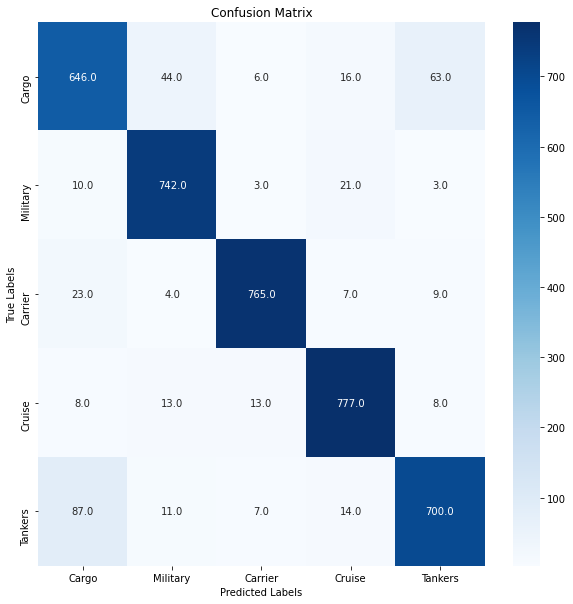

In [20]:
# CONFUSION MATRİX

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions+1)
f, ax = plt.subplots(figsize = (10,10))

sns.heatmap(conf_matrix, annot=True, fmt='.1f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Cargo', 'Military','Carrier','Cruise','Tankers']); 
ax.yaxis.set_ticklabels(['Cargo', 'Military','Carrier','Cruise','Tankers']);
plt.show();

## Prediction of the labels of the images in the test set

In [15]:
predictions_test = model.predict_classes(X_test)

In [16]:
predictions_test

array([3, 3, 3, ..., 3, 1, 2], dtype=int64)

In [18]:
test_data['category'] = predictions_test

In [19]:
test_data

,image,category
0,1007700.jpg,3
1,1011369.jpg,3
2,1051155.jpg,3
3,1062001.jpg,1
4,1069397.jpg,1
...,...,...
2675,950995.jpg,3
2676,951046.jpg,3
2677,951323.jpg,3
2678,952113.jpg,1
